In [69]:

from fastai import *
from fastai.vision.all import *
from IPython.display import clear_output, DisplayHandle

print(torch.cuda.is_available())


def update_patch(self, obj):
    clear_output(wait=True)
    self.display(obj)
DisplayHandle.update = update_patch

# this notebook takes the trained model from segment_glomeruli.ipynb and fine tunes it further with the labeled test-set
# then we can use this fully formed model and fine tune it on my glomeruli dataset


True


In [70]:
# this is to load the file back up at any time without having to retrain
project_directory = Path.cwd().joinpath('../')
output_file = 'segmentation_model_dir/dynamic_unet_seg_model-e50_b16.pkl'
learn = load_learner(project_directory.joinpath(output_file), cpu=True)


path_test = project_directory.joinpath('data/mitochondria_data/testing')
print(path_test)

test_image_paths = path_test / "images"
test_mask_paths = path_test / "masks"

test_image_files = test_image_paths.ls()
test_mask_files = test_mask_paths.ls()

/home/ncamarda/coding/endotheliosisQuantifier/scripts/../data/mitochondria_data/testing


In [71]:
# Define a function to get the mask file path from an image file path
import matplotlib.pyplot as plt
# Now, our mask isn't set up how fastai expects, in which the mask points are not all in a row. We need to change this:
# # We'll do this through an n_codes function. What this will do is run through our masks and build a set based on the unique values
# present in our masks.
# From there we will build a dictionary that will replace our points once we load in the image


def n_codes(fnames, is_partial=True):
  "Gather the codes from a list of `fnames`, full file paths"
  vals = set()
  if is_partial:
    random.shuffle(fnames)
    fnames = fnames[:10]
  for fname in fnames:
    msk = np.array(PILMask.create(fname))
    for val in np.unique(msk):
      if val not in vals:
        vals.add(val)
  vals = list(vals)
  p2c = dict()
  for i, val in enumerate(vals):
    p2c[i] = vals[i]
  return p2c


def get_mask_file(image_file, p2c, base_name='testing_groundtruth', mask_paths=test_mask_paths):
    nums = re.findall(string=image_file.name, pattern=r"\d+_\d+_\d+")[0]  # remove from list
    str_name = f'{base_name}_'+nums + image_file.suffix
    mask_path = (mask_paths/str_name)
    msk = np.array(PILMask.create(mask_path))
    mx = np.max(msk)
    for i, val in enumerate(p2c):
        # print(i, val)
        msk[msk == p2c[i]] = val
    return PILMask.create(msk)


def get_y(o):
    return get_mask_file(o, p2c)


p2c = n_codes(test_mask_files)


torch.Size([224, 224])


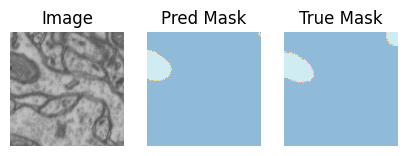

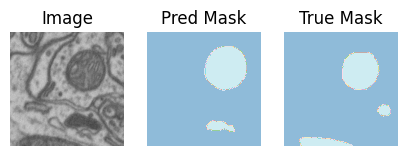

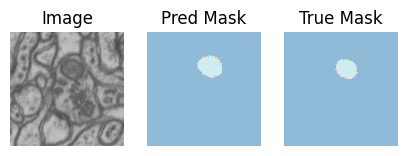

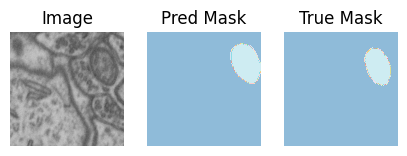

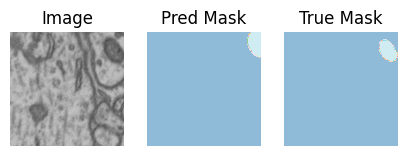

In [72]:
# test some images
def plot_side_by_side(image_file):

    fig, ax = plt.subplots(1, 3, figsize=(5, 5))
    im = PILImage.create(image_file)
    im.show(ax[0])
    ax[0].set_title("Image")

    bin_mask = learn.predict(image_file)[0]
    print(bin_mask.shape)
    msk = PILMask.create(bin_mask)
    msk.show(ax[1])
    ax[1].set_title("Pred Mask")

    msk = PILMask.create(get_mask_file(image_file, p2c, base_name='testing_groundtruth', mask_paths=test_mask_paths))
    msk.show(ax[2])
    ax[2].set_title("True Mask")


for image_fn in test_image_files[:5]:
    plot_side_by_side(image_fn)


In [73]:
# evaluate on the test set

# set up the datablock
test_mitos = DataBlock(blocks=(ImageBlock, MaskBlock(codes=np.array(['not_mito', 'mito']))),
                  splitter=RandomSplitter(valid_pct=0.2, seed=42),
                  get_items=get_image_files,
                  get_y=get_y,  # get_mask_file,  # Use the custom getter function for masks
                  item_tfms=[RandomResizedCrop(512, min_scale=0.3)],  # this is super important - upscale the crop at each batch randomly
                  batch_tfms=[*aug_transforms(size=224)],  # this is so important apparently
                  n_inp=1,
                  )

test_dls = test_mitos.dataloaders(test_image_paths, bs=16)
test_mitos.summary(test_image_paths, bs=16)


Setting-up type transforms pipelines
Found 1980 items
2 datasets of sizes 1584,396
Setting up Pipeline: PILBase.create
Setting up Pipeline: get_y -> PILBase.create

Building one sample
  Pipeline: PILBase.create
    starting from
      /home/ncamarda/coding/endotheliosisQuantifier/scripts/../data/mitochondria_data/testing/images/testing_54_2_3.tif
    applying PILBase.create gives
      PILImage mode=RGB size=256x256
  Pipeline: get_y -> PILBase.create
    starting from
      /home/ncamarda/coding/endotheliosisQuantifier/scripts/../data/mitochondria_data/testing/images/testing_54_2_3.tif
    applying get_y gives
      PILMask mode=L size=256x256
    applying PILBase.create gives
      PILMask mode=L size=256x256

Final sample: (PILImage mode=RGB size=256x256, PILMask mode=L size=256x256)


Found 1980 items
2 datasets of sizes 1584,396
Setting up Pipeline: PILBase.create
Setting up Pipeline: get_y -> PILBase.create
Setting up after_item: Pipeline: AddMaskCodes -> RandomResizedCrop -- {'

In [76]:
n_epochs = 50
lr = 5e-3
# add new data with .dls 
learn.dls = test_dls

# # fine tune it with the new data
learn.fine_tune(n_epochs, lr)


epoch,train_loss,valid_loss,dice,time


In [ ]:
learn.show_results(max_n=3, figsize=(2, 3))

In [ ]:
learn.recorder.plot_loss()


In [ ]:
rec_vals = learn.recorder.values[-1]
print(len(rec_vals))
print(f'Training loss: {rec_vals[0]}')
print(f'Validation loss: {rec_vals[1]}')
print(f'Dice Coef: {rec_vals[2]}')


In [ ]:
# save the model
os.makedirs("../segmentation_model_dir", exist_ok=True)
fname = f"dynamic_unet_seg_model-e{n_epochs}_b16_v2.pkl"
print(fname)

output_file = project_directory.joinpath(Path("segmentation_model_dir").joinpath(fname))

# saves the whole model, not just the weights
learn.export(output_file)
